<a href="https://colab.research.google.com/github/DrKenReid/GoodReads-Quotes-PDF/blob/main/GoodReads_Quotes_PDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Script Overview
This script processes quotes from a CSV file, corrects common spelling and grammatical errors, allows users to sort quotes based on various criteria, and generates a PDF file of the quotes. The script is divided into four chunks.

Requirements: download your quotes from your GoodReads profile  and upload the file as `goodreads_quotes_export.csv`.

## User Options and Parameters
In this section, we define user options for sorting quotes and set the maximum quote length. These options are saved to a file for later use.

### Functions:
- `save_user_options`: Saves user preferences to a pickle file.


In [ ]:
import pickle
import logging
!pip install fpdf
from fpdf import FPDF

user_options = {}

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def save_user_options(sort_option: str = 'random', max_quote_length: int = 0, file_path: str = 'user_options.pkl') -> None:
    """
    Save user options to a pickle file.

    Parameters:
    sort_option (str): Sorting option for quotes ('random', 'author', 'title', 'length').
    max_quote_length (int): Maximum length of quotes.
    file_path (str): Path to save the user options file.

    Returns:
    None
    """
    user_options = {
        'sort_option': sort_option,
        'max_quote_length': max_quote_length
    }

    try:
        with open(file_path, 'wb') as file:
            pickle.dump(user_options, file)
        logging.info("User options saved successfully.")
    except Exception as e:
        logging.error(f"Error saving user options: {e}")

save_user_options(sort_option='random', max_quote_length=0)

## Chunk 2: Load and Process Quotes
In this chunk, we define a function to load and process quotes from a CSV file. This includes handling potential errors such as missing or empty files and truncating quotes to a specified maximum length.

### Functions:
- `load_and_process_quotes`: Loads quotes from a CSV file, performs basic cleaning, and truncates quotes if necessary.

### Example Usage:
This section also demonstrates how to use the `load_and_process_quotes` function to load and process quotes.


In [ ]:
import pandas as pd
import re

def replace_unicode_chars(text):
    """
    Replace specific unicode characters in a string with ASCII equivalents.

    Parameters:
    text (str): The input text with unicode characters.

    Returns:
    str: Text with replaced unicode characters.
    """
    if not isinstance(text, str):
        return text
    replacements = {
        '\u2019': "'", '\u2018': "'", '\u201C': '"', '\u201D': '"',
        '\u2013': '-', '\u2014': '-', '\u2026': '...', '\u00E9': 'e',
        '\u00E8': 'e', '\u00E0': 'a', '\u00F1': 'n', '\u00FC': 'u'
    }
    pattern = re.compile("|".join(re.escape(key) for key in replacements.keys()))
    return pattern.sub(lambda x: replacements[x.group()], text)


def remove_html_tags(text):
    """
    Remove HTML-like tags from a string.

    Parameters:
    text (str): The input text with HTML tags.

    Returns:
    str: Text with HTML tags removed.
    """
    return re.sub(re.compile('<.*?>'), '', text) if isinstance(text, str) else text


def load_and_process_quotes(file_path='goodreads_quotes_export.csv'):
    """
    Load and process quotes from a CSV file.

    Parameters:
    file_path (str): Path to the CSV file containing quotes.

    Returns:
    pd.DataFrame: Processed DataFrame with quotes.
    """
    try:
        quotes_df = pd.read_csv(file_path).dropna(subset=['Quote'])
    except (FileNotFoundError, pd.errors.EmptyDataError, pd.errors.ParserError) as e:
        print(f"Error: {str(e)}")
        return None

    # Clean quotes, author, and book columns
    quotes_df['Quote'] = quotes_df['Quote'].apply(lambda x: replace_unicode_chars(remove_html_tags(x)))
    for col in ['Author', 'Book']:
        quotes_df[col] = quotes_df[col].apply(replace_unicode_chars)

    # Sort quotes based on user option
    sort_option = user_options.get('sort_option', 'random')
    if sort_option == 'author':
        quotes_df = quotes_df.sort_values(by='Author')
    elif sort_option == 'title':
        quotes_df = quotes_df.sort_values(by='Book')
    elif sort_option == 'length':
        quotes_df = quotes_df.assign(Quote_length=quotes_df['Quote'].str.len()).sort_values(by='Quote_length').drop(columns='Quote_length')
    elif sort_option == 'random':
        quotes_df = quotes_df.sample(frac=1).reset_index(drop=True)
        print("Quotes have been shuffled randomly.")

    return quotes_df


quotes_df = load_and_process_quotes()
if quotes_df is not None:
    print("Quotes loaded and processed successfully.")


Quotes have been shuffled randomly.
Quotes loaded and processed successfully.


## Chunk 3: Create Quote PDF
In this chunk, we define a function to create a PDF file containing the quotes. The function formats the quotes, alternates their alignment, and adds author and book information.

### Functions:
- `create_quote_pdf`: Generates a PDF file with quotes from a DataFrame.

### Example Usage:
This section demonstrates how to use the `create_quote_pdf` function to generate a PDF file from the processed quotes.


In [ ]:
import textwrap
from fpdf import FPDF
import pandas as pd
import re

# Define user options (these would typically be loaded from a file or user input)
user_options = {
    'sort_option': 'random',
    'max_quote_length': 0  # Set to 0 to indicate no truncation
}

def replace_unicode_chars(text):
    """
    Replace specific unicode characters in a string with ASCII equivalents.
    """
    if not isinstance(text, str):
        return text
    replacements = {
        '\u2019': "'", '\u2018': "'", '\u201C': '"', '\u201D': '"',
        '\u2013': '-', '\u2014': '-', '\u2026': '...', '\u00E9': 'e',
        '\u00E8': 'e', '\u00E0': 'a', '\u00F1': 'n', '\u00FC': 'u'
    }
    pattern = re.compile("|".join(re.escape(key) for key in replacements.keys()))
    return pattern.sub(lambda x: replacements[x.group()], text)

def remove_html_tags(text):
    """
    Remove HTML-like tags from a string.
    """
    return re.sub(re.compile('<.*?>'), '', text) if isinstance(text, str) else text

def load_and_process_quotes(file_path='goodreads_quotes_export.csv'):
    """
    Load and process quotes from a CSV file.

    Parameters:
        file_path (str): Path to the CSV file containing quotes.

    Returns:
        pd.DataFrame: Processed DataFrame with quotes.
    """
    try:
        quotes_df = pd.read_csv(file_path).dropna(subset=['Quote'])
    except (FileNotFoundError, pd.errors.EmptyDataError, pd.errors.ParserError) as e:
        print(f"Error: {str(e)}")
        return None

    # Clean quotes, author, and book columns
    quotes_df['Quote'] = quotes_df['Quote'].apply(lambda x: replace_unicode_chars(remove_html_tags(x)))
    for col in ['Author', 'Book']:
        quotes_df[col] = quotes_df[col].apply(replace_unicode_chars)

    # Sort quotes based on user option
    sort_option = user_options.get('sort_option', 'random')
    if sort_option == 'author':
        quotes_df = quotes_df.sort_values(by='Author')
    elif sort_option == 'title':
        quotes_df = quotes_df.sort_values(by='Book')
    elif sort_option == 'length':
        quotes_df = quotes_df.assign(Quote_length=quotes_df['Quote'].str.len()).sort_values(by='Quote_length').drop(columns='Quote_length')
    elif sort_option == 'random':
        quotes_df = quotes_df.sample(frac=1).reset_index(drop=True)
        print("Quotes have been shuffled randomly.")

    return quotes_df

from fpdf import FPDF

class PDF(FPDF):
    """
    Custom PDF class for generating a PDF with quotes.
    """
    def header(self):
        self.set_font('Arial', 'B', 12)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)

    def add_quote(self, quote_text, author_book_text, is_left_aligned=True):
        """
        Add a quote to the PDF.

        Parameters:
        quote_text (str): The quote text.
        author_book_text (str): The author and book information.
        is_left_aligned (bool): Whether the text is left aligned.

        Returns:
        None
        """
        max_width = self.w - 2 * self.l_margin
        self.set_font('Arial', 'B' if len(quote_text.split()) < 20 else '', 12)
        self.multi_cell(max_width, 10, quote_text, align='L' if is_left_aligned else 'R')
        self.set_font('Arial', 'I', 10)
        self.multi_cell(max_width, 10, author_book_text, align='L' if is_left_aligned else 'R')
        self.ln(10)  # Add extra spacing between quotes


def format_quotes_for_pdf(quotes_df):
    """
    Format quotes for inclusion in the PDF.

    Parameters:
    quotes_df (pd.DataFrame): DataFrame with quotes.

    Returns:
    list: List of tuples containing quote text, author/book text, and alignment.
    """
    return [(row['Quote'], f"- {row['Author']} ({row['Book']})", i % 2 == 0) for i, row in quotes_df.iterrows()]


def text_to_pdf(formatted_texts, filename):
    """
    Generate a PDF with the formatted quotes.

    Parameters:
    formatted_texts (list): List of tuples containing quote text, author/book text, and alignment.
    filename (str): Name of the output PDF file.

    Returns:
    None
    """
    pdf = PDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    for quote_text, author_book_text, is_left_aligned in formatted_texts:
        pdf.add_quote(quote_text, author_book_text, is_left_aligned)

    pdf.output(filename)

quotes_df = load_and_process_quotes()
if quotes_df is not None:
    formatted_texts = format_quotes_for_pdf(quotes_df)
    text_to_pdf(formatted_texts, 'quotes.pdf')
    print("Quotes PDF is saved at: 'quotes.pdf'")

Quotes have been shuffled randomly.
Quotes PDF is saved at: 'quotes.pdf'


## Chunk 4: Visualizing Quote Data
In this chunk, we define functions to create various visualizations from the quotes data. These functions generate plots to show the distribution of word counts, the average quote length by author, the number of quotes by author, and the word count per author across quotes.

### Functions:
plot_word_count_distribution: Generates a histogram showing the distribution of word counts in quotes.
plot_average_quote_length_by_author: Generates a bar plot showing the top 20 authors by average quote length.
plot_number_of_quotes_by_author: Generates a bar plot showing the top 20 authors by the number of quotes.
plot_word_count_per_author_boxplot: Generates a box plot showing the distribution of word counts per author across quotes for the top 20 authors.
### Example Usage:
This section demonstrates how to use the defined functions to visualize data from a DataFrame containing quotes.

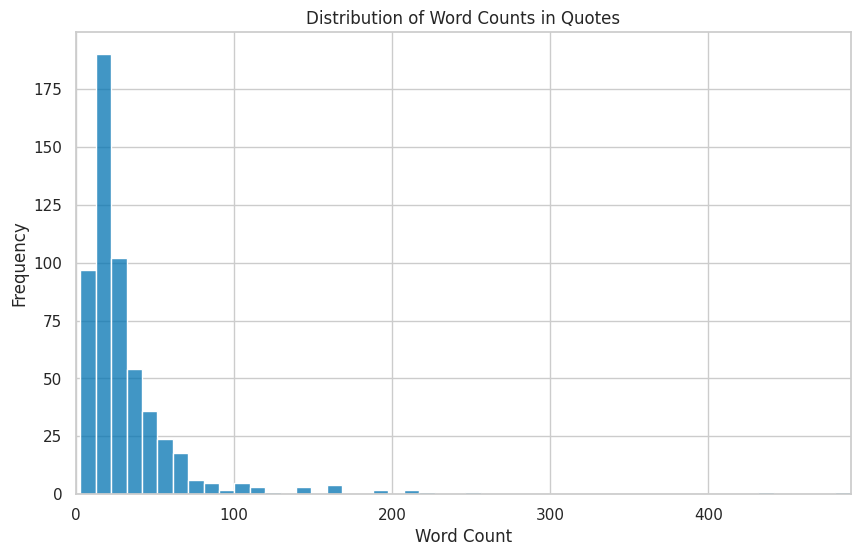

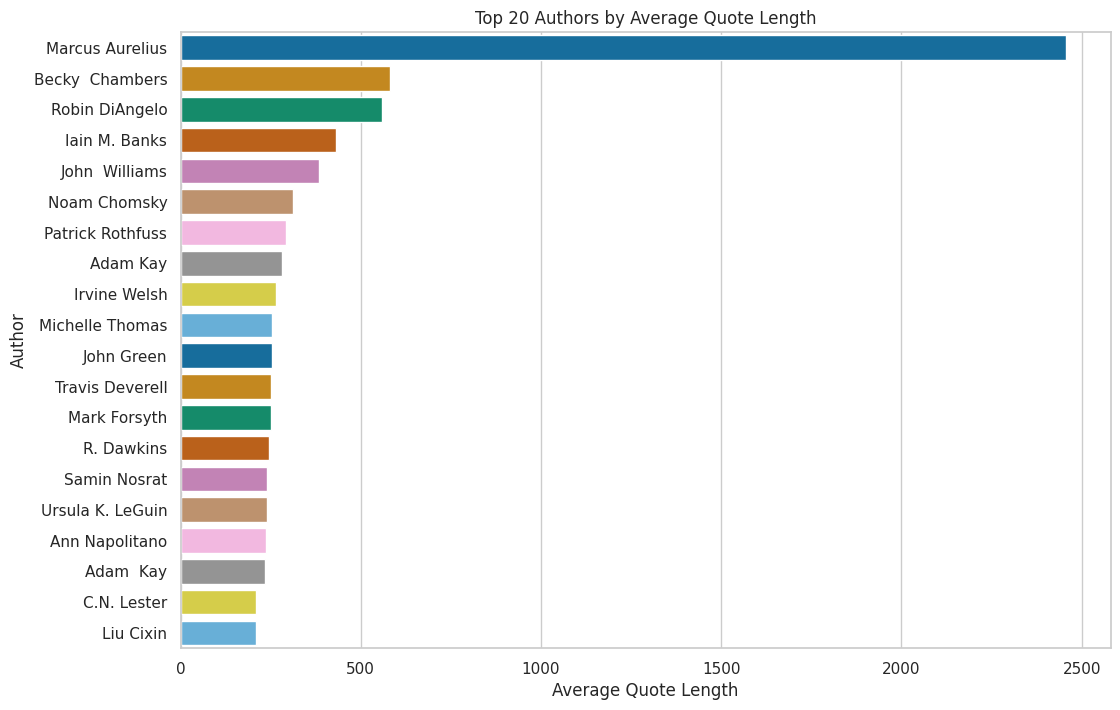

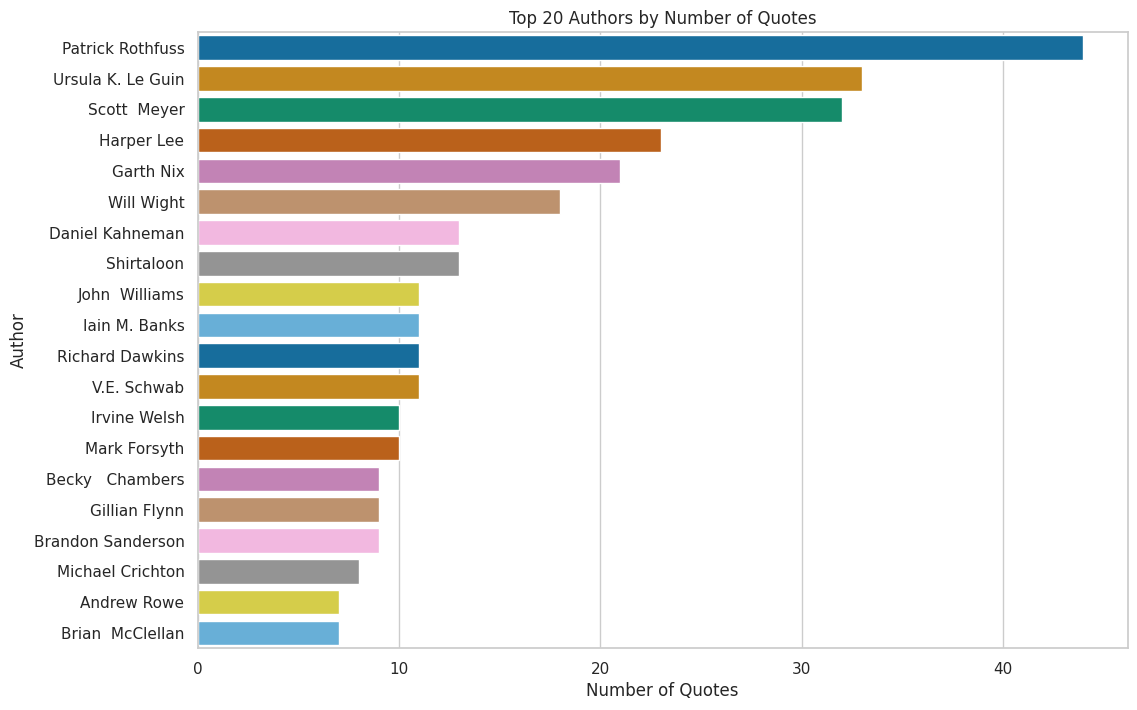

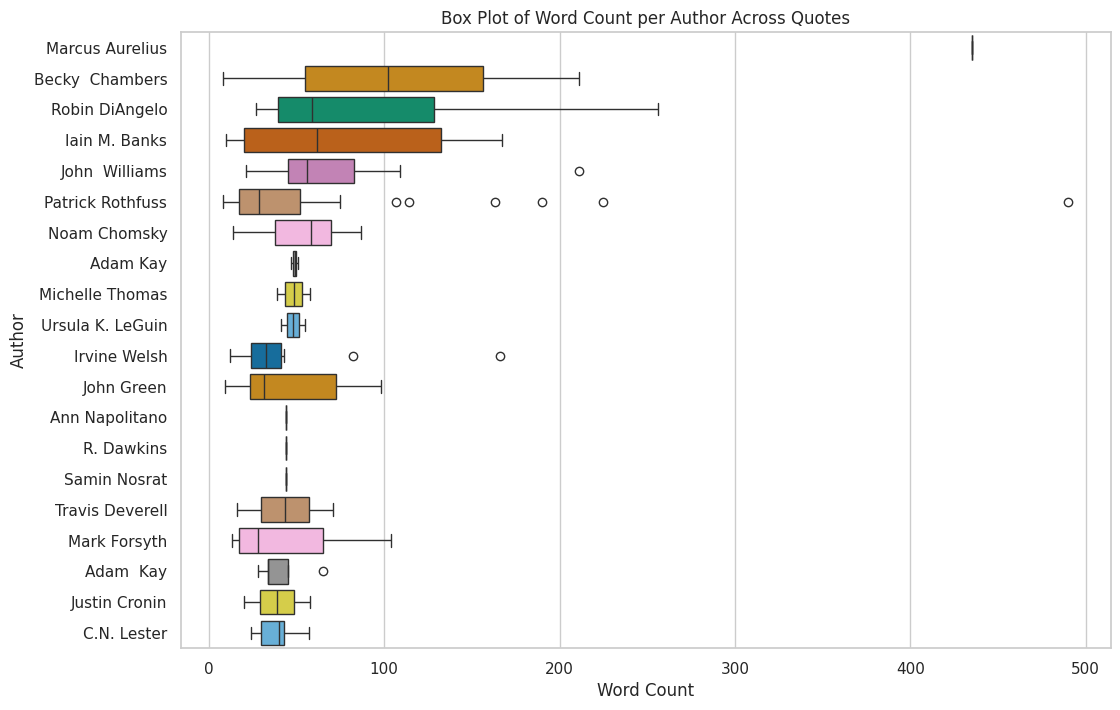

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the seaborn style and color palette
sns.set(style="whitegrid")
sns.set_palette("colorblind")

def plot_word_count_distribution(dataframe):
    """
    Generate a histogram showing the distribution of word counts in quotes.

    Parameters:
    dataframe (pd.DataFrame): DataFrame containing quotes data.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    dataframe['word_count'] = dataframe['Quote'].apply(lambda x: len(x.split()))
    max_word_count = dataframe['word_count'].max()
    sns.histplot(data=dataframe, x='word_count', bins=50, kde=False)
    plt.xlim(0, max_word_count)  # Set x-axis limit
    plt.title('Distribution of Word Counts in Quotes')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()

def plot_average_quote_length_by_author(dataframe):
    """
    Generate a bar plot showing the top 20 authors by average quote length.

    Parameters:
    dataframe (pd.DataFrame): DataFrame containing quotes data.

    Returns:
    None
    """
    author_avg_length = dataframe.groupby('Author')['Quote'].apply(lambda x: x.str.len().mean()).reset_index()
    top_20_authors = author_avg_length.sort_values(by='Quote', ascending=False).head(20)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_20_authors, x='Quote', y='Author', hue='Author', dodge=False, palette="colorblind", legend=False)
    plt.title('Top 20 Authors by Average Quote Length')
    plt.xlabel('Average Quote Length')
    plt.ylabel('Author')
    plt.show()

def plot_number_of_quotes_by_author(dataframe):
    """
    Generate a bar plot showing the top 20 authors by the number of quotes.

    Parameters:
    dataframe (pd.DataFrame): DataFrame containing quotes data.

    Returns:
    None
    """
    author_quote_count = dataframe['Author'].value_counts().reset_index()
    author_quote_count.columns = ['Author', 'Number of Quotes']
    top_20_authors = author_quote_count.head(20)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_20_authors, x='Number of Quotes', y='Author', hue='Author', dodge=False, palette="colorblind", legend=False)
    plt.title('Top 20 Authors by Number of Quotes')
    plt.xlabel('Number of Quotes')
    plt.ylabel('Author')
    plt.show()

def plot_word_count_per_author_boxplot(dataframe):
    """
    Generate a box plot showing the distribution of word counts per author across quotes for the top 20 authors.

    Parameters:
    dataframe (pd.DataFrame): DataFrame containing quotes data.

    Returns:
    None
    """
    dataframe['word_count'] = dataframe['Quote'].apply(lambda x: len(x.split()))
    author_mean_word_count = dataframe.groupby('Author')['word_count'].mean().reset_index()
    top_20_authors = author_mean_word_count.nlargest(20, 'word_count')['Author']
    top_20_data = dataframe[dataframe['Author'].isin(top_20_authors)].copy()
    top_20_data['Author'] = pd.Categorical(top_20_data['Author'], categories=top_20_authors, ordered=True)
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=top_20_data.sort_values('Author'), x='word_count', y='Author', hue='Author', dodge=False, palette="colorblind", legend=False)
    plt.title('Box Plot of Word Count per Author Across Quotes')
    plt.xlabel('Word Count')
    plt.ylabel('Author')
    plt.show()

# Call all the plot functions
plot_word_count_distribution(quotes_df)
plot_average_quote_length_by_author(quotes_df)
plot_number_of_quotes_by_author(quotes_df)
plot_word_count_per_author_boxplot(quotes_df)